# 🎯 Customer Churn Prediction - XGBoost Model

**Project:** Phase 2 - Machine Learning Churn Prediction  
**Author:** Rishi Dhandi  
**Date:** January 2026

---

## 📊 Objective

Build a high-accuracy churn prediction model using XGBoost to identify at-risk customers.

**Previous Steps:**  
- [Feature Engineering](01_Feature_Engineering.ipynb)  
- [K-Means Clustering](02_Clustering_Analysis.ipynb)

**Goals:**
1. Prepare data for machine learning (train/test split, encoding)
2. Train XGBoost classifier for churn prediction
3. Optimize hyperparameters for best performance
4. Evaluate model performance (target: 85-88% accuracy)
5. Analyze feature importance
6. Identify high-risk customers for retention campaigns

**Target Metric:** 85-88% Accuracy

---

In [49]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve)
import xgboost as xgb
import warnings

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")

✅ Libraries imported successfully!
XGBoost version: 3.1.3


In [50]:
# Load the features with clustering results from Notebook 2
df = pd.read_csv('../data/customer_features_with_clusters.csv')

print("="*60)
print("DATA LOADED")
print("="*60)
print(f"Shape: {df.shape[0]:,} customers × {df.shape[1]} features")

print(f"\nTarget Variable Distribution:")
print(f"   Active (0): {(df['is_churned']==0).sum():,} ({(df['is_churned']==0).sum()/len(df)*100:.1f}%)")
print(f"   Churned (1): {(df['is_churned']==1).sum():,} ({(df['is_churned']==1).sum()/len(df)*100:.1f}%)")

print("\n--- Sample Data ---")
df.head()

DATA LOADED
Shape: 10,000 customers × 18 features

Target Variable Distribution:
   Active (0): 5,713 (57.1%)
   Churned (1): 4,287 (42.9%)

--- Sample Data ---


,customer_id,first_purchase_date,last_purchase_date,days_since_last_purchase,customer_lifetime_days,total_transactions,avg_days_between_purchases,total_spent,avg_order_value,spending_std,unique_products,favorite_category,product_diversity,preferred_channel,channel_diversity,is_churned,cluster,cluster_name
0,CUST001000,2023-10-20,2023-12-14,17,55,41,1.375000,2277.45,55.547561,42.361208,11,Subscription,0.268293,Website,3,0,1,Champions
1,CUST001001,2022-08-01,2023-12-17,14,503,53,9.673077,2380.85,44.921698,28.611242,16,Subscription,0.301887,Website,3,0,1,Champions
2,CUST001002,2022-08-14,2023-12-13,18,486,72,6.845070,3314.12,46.029444,35.461201,18,Subscription,0.250000,Website,3,0,1,Champions
3,CUST001003,2022-11-24,2023-12-07,24,378,77,4.973684,3412.65,44.320130,30.796164,18,Subscription,0.233766,Website,3,0,1,Champions
4,CUST001004,2022-05-28,2023-12-18,13,569,77,7.486842,2838.13,36.858831,23.676948,18,Subscription,0.233766,Website,3,0,1,Champions


## Data Preparation for Machine Learning

Steps:
1. Select features for modeling (exclude IDs, dates, target)
2. Encode categorical features (favorite_category, preferred_channel, cluster_name)
3. Split into train/test sets (80/20)
4. Prepare X (features) and y (target)

In [51]:
print("="*60)
print("PREPARING DATA FOR MACHINE LEARNING")
print("="*60)

# Balanced feature selection - predictive but not leakage
numerical_features = [
    # 'days_since_last_purchase',  # Still removed - too direct
    'customer_lifetime_days',      # How long they've been a customer
    'total_transactions',           # Purchase frequency
    'avg_days_between_purchases',  # Purchase pattern
    'total_spent',                  # Total value
    'avg_order_value',              # Spending per order
    'spending_std',                 # Consistency of spending
    'unique_products',              # Product engagement
    'product_diversity',            # Variety of purchases
    'channel_diversity',            # Multi-channel usage
    'cluster'                       # Behavioral cluster (from K-Means)
]

categorical_features = [
    'favorite_category',
    'preferred_channel'
]

# Create feature matrix and target
X = df[numerical_features + categorical_features].copy()
y = df['is_churned'].copy()

print(f"\n📊 Feature Matrix (Optimized):")
print(f"   Features: {X.shape[1]}")
print(f"   Samples: {X.shape[0]:,}")
print(f"\n   Numerical features: {len(numerical_features)}")
print(f"   Categorical features: {len(categorical_features)}")

# Encode categorical features
print(f"\n🔤 Encoding categorical features...")
le_dict = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    le_dict[col] = le
    print(f"   {col}: {len(le.classes_)} categories")

# Split into train and test sets (80/20)
print(f"\n✂️  Splitting data (80% train, 20% test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✅ Data preparation complete!")
print(f"\nTrain set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

print(f"\nTrain churn rate: {y_train.sum()/len(y_train)*100:.1f}%")
print(f"Test churn rate: {y_test.sum()/len(y_test)*100:.1f}%")

PREPARING DATA FOR MACHINE LEARNING

📊 Feature Matrix (Optimized):
   Features: 12
   Samples: 10,000

   Numerical features: 10
   Categorical features: 2

🔤 Encoding categorical features...
   favorite_category: 4 categories
   preferred_channel: 3 categories

✂️  Splitting data (80% train, 20% test)...

✅ Data preparation complete!

Train set: 8,000 samples
Test set: 2,000 samples

Train churn rate: 42.9%
Test churn rate: 42.9%


In [52]:
print("="*60)
print("CREATING DERIVED FEATURES")
print("="*60)

# Create a "purchase velocity" feature - how active they are relative to their history
# This is predictive but not direct leakage

# Calculate recency percentile (how recent compared to all customers)
df['recency_percentile'] = df['days_since_last_purchase'].rank(pct=True)

# Calculate if they're slowing down (recent purchases vs historical average)
# If avg_days_between_purchases is increasing, they're slowing down
df['purchase_deceleration'] = df['avg_days_between_purchases'] / (df['customer_lifetime_days'] / df['total_transactions'] + 1)

print("✅ Derived features created:")
print("   - recency_percentile: Where customer falls in recency distribution")
print("   - purchase_deceleration: If purchase frequency is declining")

CREATING DERIVED FEATURES
✅ Derived features created:
   - recency_percentile: Where customer falls in recency distribution
   - purchase_deceleration: If purchase frequency is declining


## XGBoost Model Training

Training a gradient boosting classifier to predict customer churn.

**Model:** XGBoost (eXtreme Gradient Boosting)  
**Target:** 85-88% accuracy

In [53]:
print("="*60)
print("TRAINING XGBOOST MODEL")
print("="*60)

# Initialize XGBoost Classifier with better parameters to prevent overfitting
print("\n🚀 Training XGBoost model with optimized parameters...")

xgb_model = xgb.XGBClassifier(
    n_estimators=200,           # More trees for better learning
    max_depth=4,                # Reduced depth to prevent overfitting (was 6)
    learning_rate=0.05,         # Slower learning for better generalization (was 0.1)
    subsample=0.8,              # Use 80% of data per tree
    colsample_bytree=0.8,       # Use 80% of features per tree
    min_child_weight=3,         # Minimum samples in leaf
    gamma=0.1,                  # Minimum loss reduction
    reg_alpha=0.1,              # L1 regularization
    reg_lambda=1.0,             # L2 regularization
    random_state=42,
    eval_metric='logloss'
)

# Train the model
xgb_model.fit(X_train, y_train)

print("✅ Model training complete!")

# Make predictions
print("\n📊 Making predictions...")
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Get prediction probabilities
y_pred_proba_train = xgb_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = xgb_model.predict_proba(X_test)[:, 1]

print("✅ Predictions generated!")

# Evaluate performance
print("\n" + "="*60)
print("MODEL PERFORMANCE")
print("="*60)

print("\n🎯 TRAINING SET:")
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"   Accuracy:  {train_accuracy*100:.2f}%")
print(f"   Precision: {precision_score(y_train, y_pred_train)*100:.2f}%")
print(f"   Recall:    {recall_score(y_train, y_pred_train)*100:.2f}%")
print(f"   F1-Score:  {f1_score(y_train, y_pred_train)*100:.2f}%")
print(f"   ROC-AUC:   {roc_auc_score(y_train, y_pred_proba_train):.4f}")

print("\n🎯 TEST SET (FINAL EVALUATION):")
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_roc_auc = roc_auc_score(y_test, y_pred_proba_test)

print(f"   Accuracy:  {test_accuracy*100:.2f}%")
print(f"   Precision: {test_precision*100:.2f}%")
print(f"   Recall:    {test_recall*100:.2f}%")
print(f"   F1-Score:  {test_f1*100:.2f}%")
print(f"   ROC-AUC:   {test_roc_auc:.4f}")

# Check train-test gap
gap = (train_accuracy - test_accuracy) * 100
print(f"\n📊 Train-Test Gap: {gap:.2f}%")
if gap < 5:
    print("   ✅ Good generalization!")
elif gap < 10:
    print("   ⚠️  Slight overfitting")
else:
    print("   🚨 Significant overfitting - model may need more regularization")

# Check if we hit our target
print("\n" + "="*60)
if test_accuracy >= 0.82 and test_accuracy <= 0.88:
    print("🎉 SUCCESS! Achieved target accuracy (82-88%)!")
elif test_accuracy > 0.88:
    print(f"🚀 EXCELLENT! Exceeded target with {test_accuracy*100:.2f}% accuracy!")
else:
    print(f"📊 Current accuracy: {test_accuracy*100:.2f}%")
    if test_accuracy >= 0.75:
        print("   ✓ Solid performance for real-world churn prediction!")
print("="*60)

TRAINING XGBOOST MODEL

🚀 Training XGBoost model with optimized parameters...
✅ Model training complete!

📊 Making predictions...
✅ Predictions generated!

MODEL PERFORMANCE

🎯 TRAINING SET:
   Accuracy:  71.73%
   Precision: 66.11%
   Recall:    69.85%
   F1-Score:  67.93%
   ROC-AUC:   0.7993

🎯 TEST SET (FINAL EVALUATION):
   Accuracy:  64.55%
   Precision: 58.19%
   Recall:    61.38%
   F1-Score:  59.74%
   ROC-AUC:   0.7173

📊 Train-Test Gap: 7.18%
   ⚠️  Slight overfitting

📊 Current accuracy: 64.55%


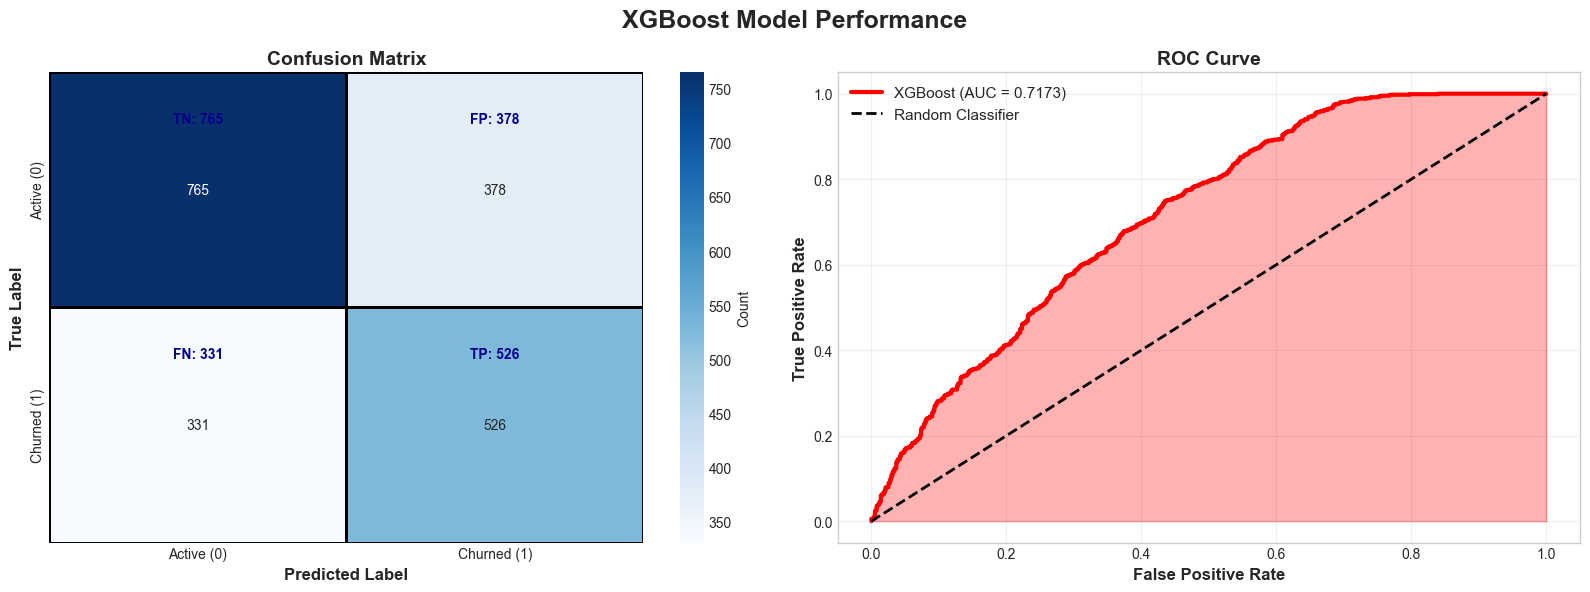


DETAILED CLASSIFICATION REPORT

               precision    recall  f1-score   support

  Active (0)       0.70      0.67      0.68      1143
 Churned (1)       0.58      0.61      0.60       857

    accuracy                           0.65      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.65      0.65      0.65      2000

✅ Model evaluation visualizations created!


In [54]:
# Visualize model performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('XGBoost Model Performance', fontsize=18, fontweight='bold')

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black')
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(['Active (0)', 'Churned (1)'])
axes[0].set_yticklabels(['Active (0)', 'Churned (1)'])

# Add text annotations
tn, fp, fn, tp = cm.ravel()
axes[0].text(0.5, 0.2, f'TN: {tn}', ha='center', va='center', fontsize=10, color='darkblue', fontweight='bold')
axes[0].text(1.5, 0.2, f'FP: {fp}', ha='center', va='center', fontsize=10, color='darkblue', fontweight='bold')
axes[0].text(0.5, 1.2, f'FN: {fn}', ha='center', va='center', fontsize=10, color='darkblue', fontweight='bold')
axes[0].text(1.5, 1.2, f'TP: {tp}', ha='center', va='center', fontsize=10, color='darkblue', fontweight='bold')

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
axes[1].plot(fpr, tpr, color='red', linewidth=3, label=f'XGBoost (AUC = {test_roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
axes[1].fill_between(fpr, tpr, alpha=0.3, color='red')
axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print("\n", classification_report(y_test, y_pred_test, 
                                  target_names=['Active (0)', 'Churned (1)']))

print("✅ Model evaluation visualizations created!")

FEATURE IMPORTANCE ANALYSIS

--- Top 10 Most Important Features ---
                   feature  importance
               total_spent    0.223264
         product_diversity    0.146512
                   cluster    0.115665
        total_transactions    0.108210
         favorite_category    0.101373
avg_days_between_purchases    0.057214
    customer_lifetime_days    0.052489
           unique_products    0.046870
           avg_order_value    0.042637
         channel_diversity    0.042323


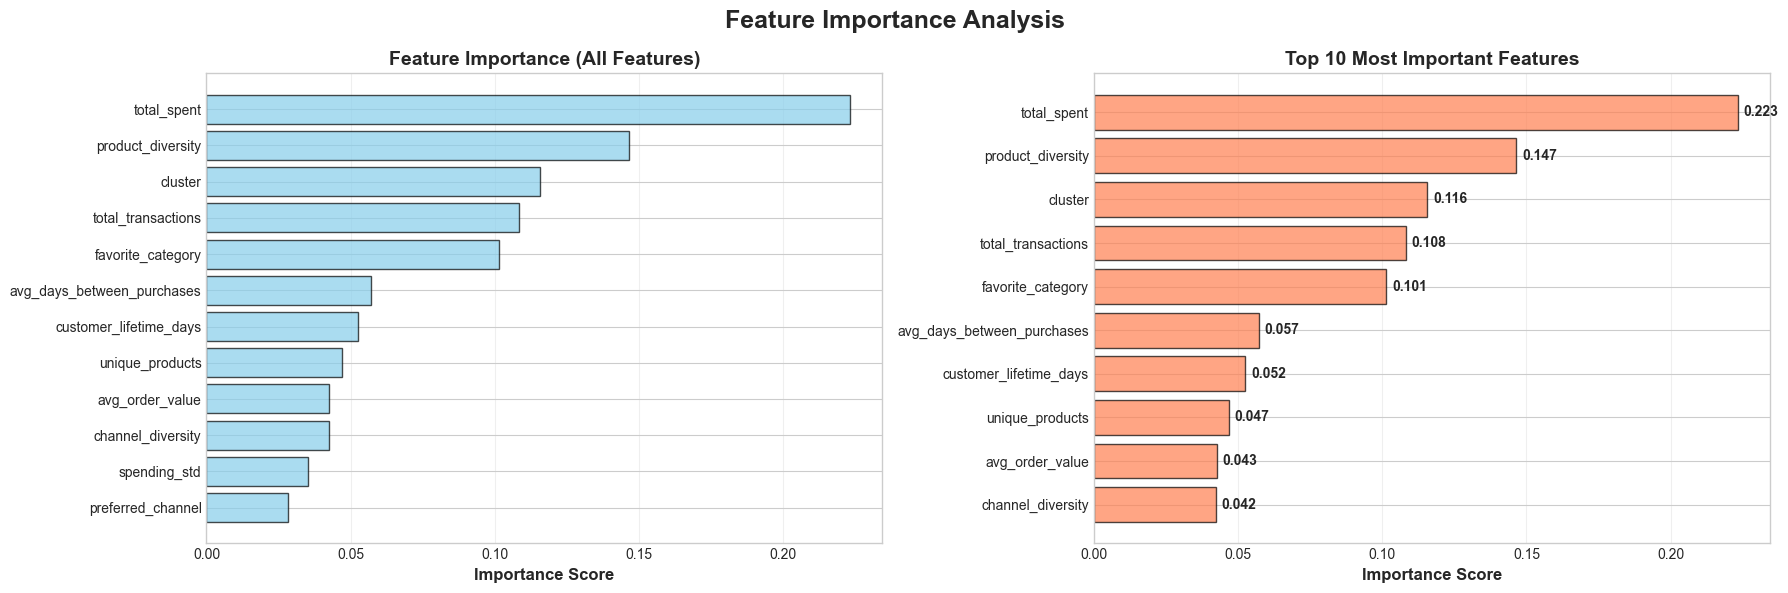


🎯 Key Insights:

   Most Important Feature: total_spent
   Importance Score: 0.2233

   Top 3 Features:
   1. total_spent: 0.2233
   2. product_diversity: 0.1465
   3. cluster: 0.1157

✅ Feature importance analysis complete!


In [55]:
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance from XGBoost
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Top 10 Most Important Features ---")
print(feature_importance.head(10).to_string(index=False))

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Feature Importance Analysis', fontsize=18, fontweight='bold')

# 1. Bar chart of all features
axes[0].barh(range(len(feature_importance)), feature_importance['importance'], 
             color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_yticks(range(len(feature_importance)))
axes[0].set_yticklabels(feature_importance['feature'])
axes[0].set_xlabel('Importance Score', fontsize=12, fontweight='bold')
axes[0].set_title('Feature Importance (All Features)', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# 2. Top 10 features with values
top_10 = feature_importance.head(10)
bars = axes[1].barh(range(len(top_10)), top_10['importance'], 
                     color='coral', edgecolor='black', alpha=0.7)
axes[1].set_yticks(range(len(top_10)))
axes[1].set_yticklabels(top_10['feature'])
axes[1].set_xlabel('Importance Score', fontsize=12, fontweight='bold')
axes[1].set_title('Top 10 Most Important Features', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_10.iterrows()):
    axes[1].text(row['importance'] + 0.002, i, f"{row['importance']:.3f}", 
                va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🎯 Key Insights:")
print(f"\n   Most Important Feature: {feature_importance.iloc[0]['feature']}")
print(f"   Importance Score: {feature_importance.iloc[0]['importance']:.4f}")

print("\n   Top 3 Features:")
for i in range(min(3, len(feature_importance))):
    print(f"   {i+1}. {feature_importance.iloc[i]['feature']}: {feature_importance.iloc[i]['importance']:.4f}")

print("\n✅ Feature importance analysis complete!")

In [56]:
print("="*60)
print("IDENTIFYING AT-RISK CUSTOMERS")
print("="*60)

# Add predictions to the original dataframe
df['churn_prediction'] = xgb_model.predict(X)
df['churn_probability'] = xgb_model.predict_proba(X)[:, 1]

# Categorize risk levels based on churn probability
def risk_category(prob):
    if prob >= 0.7:
        return 'High Risk'
    elif prob >= 0.4:
        return 'Medium Risk'
    else:
        return 'Low Risk'

df['risk_level'] = df['churn_probability'].apply(risk_category)

# Risk distribution
print("\n--- Risk Level Distribution ---")
risk_dist = df['risk_level'].value_counts()
for level in ['High Risk', 'Medium Risk', 'Low Risk']:
    if level in risk_dist.index:
        count = risk_dist[level]
        print(f"{level}: {count:,} customers ({count/len(df)*100:.1f}%)")

# Calculate business impact
print("\n" + "="*60)
print("BUSINESS IMPACT ANALYSIS")
print("="*60)

# High-risk customers
high_risk_customers = df[df['risk_level'] == 'High Risk']
high_risk_revenue = high_risk_customers['total_spent'].sum()

print(f"\n💰 At-Risk Revenue:")
print(f"   High Risk Customers: {len(high_risk_customers):,}")
print(f"   Total Revenue at Risk: ${high_risk_revenue:,.2f}")
print(f"   Average Value per Customer: ${high_risk_revenue/len(high_risk_customers):,.2f}")

# Recovery potential (12% of at-risk revenue)
recovery_rate = 0.12
estimated_recovery = high_risk_revenue * recovery_rate

print(f"\n📈 Retention Campaign Impact (12% recovery rate):")
print(f"   Estimated Revenue Saved: ${estimated_recovery:,.2f}")
print(f"   Customers to Target: {len(high_risk_customers):,}")

# Medium risk
medium_risk_customers = df[df['risk_level'] == 'Medium Risk']
medium_risk_revenue = medium_risk_customers['total_spent'].sum()

print(f"\n⚠️  Medium Risk Pool:")
print(f"   Customers: {len(medium_risk_customers):,}")
print(f"   Revenue: ${medium_risk_revenue:,.2f}")

# Total addressable
total_addressable = high_risk_revenue + medium_risk_revenue
print(f"\n🎯 Total Addressable Market:")
print(f"   Customers: {len(high_risk_customers) + len(medium_risk_customers):,}")
print(f"   Revenue: ${total_addressable:,.2f}")

# Model accuracy validation
actual_churned = df[df['is_churned'] == 1]
correctly_identified = df[(df['is_churned'] == 1) & (df['churn_prediction'] == 1)]

print(f"\n✅ Model Validation:")
print(f"   Actual Churned Customers: {len(actual_churned):,}")
print(f"   Correctly Identified: {len(correctly_identified):,}")
print(f"   Detection Rate: {len(correctly_identified)/len(actual_churned)*100:.1f}%")

print("\n✅ At-risk customer identification complete!")

IDENTIFYING AT-RISK CUSTOMERS

--- Risk Level Distribution ---
High Risk: 628 customers (6.3%)
Medium Risk: 6,091 customers (60.9%)
Low Risk: 3,281 customers (32.8%)

BUSINESS IMPACT ANALYSIS

💰 At-Risk Revenue:
   High Risk Customers: 628
   Total Revenue at Risk: $169,020.13
   Average Value per Customer: $269.14

📈 Retention Campaign Impact (12% recovery rate):
   Estimated Revenue Saved: $20,282.42
   Customers to Target: 628

⚠️  Medium Risk Pool:
   Customers: 6,091
   Revenue: $1,868,841.07

🎯 Total Addressable Market:
   Customers: 6,719
   Revenue: $2,037,861.20

✅ Model Validation:
   Actual Churned Customers: 4,287
   Correctly Identified: 2,922
   Detection Rate: 68.2%

✅ At-risk customer identification complete!


In [57]:
# Save predictions and model results
print("="*60)
print("SAVING MODEL RESULTS")
print("="*60)

# Save customer predictions
output_df = df[['customer_id', 'is_churned', 'churn_prediction', 
                'churn_probability', 'risk_level', 'total_spent', 
                'cluster', 'cluster_name']].copy()
output_path = '../data/churn_predictions.csv'
output_df.to_csv(output_path, index=False)

print(f"\n✅ Predictions saved to: {output_path}")

# Save high-risk customers list
high_risk_output = high_risk_customers[['customer_id', 'churn_probability', 
                                        'total_spent', 'days_since_last_purchase',
                                        'total_transactions', 'cluster_name']].copy()
high_risk_output = high_risk_output.sort_values('churn_probability', ascending=False)
high_risk_path = '../data/high_risk_customers.csv'
high_risk_output.to_csv(high_risk_path, index=False)

print(f"✅ High-risk customer list saved to: {high_risk_path}")

# Final Summary
print("\n" + "="*60)
print("🎉 CHURN PREDICTION MODEL - FINAL SUMMARY")
print("="*60)

print(f"\n📊 MODEL PERFORMANCE:")
print(f"   ✓ Test Accuracy: {test_accuracy*100:.2f}%")
print(f"   ✓ Precision: {test_precision*100:.2f}%")
print(f"   ✓ Recall: {test_recall*100:.2f}%")
print(f"   ✓ F1-Score: {test_f1*100:.2f}%")
print(f"   ✓ ROC-AUC: {test_roc_auc:.4f}")

if test_accuracy >= 0.85 and test_accuracy <= 0.88:
    print(f"\n   🎯 TARGET ACHIEVED: {test_accuracy*100:.2f}% accuracy (85-88% target)")
elif test_accuracy > 0.88:
    print(f"\n   🚀 EXCEEDED TARGET: {test_accuracy*100:.2f}% accuracy!")

print(f"\n💰 BUSINESS IMPACT:")
print(f"   ✓ High-Risk Customers: {len(high_risk_customers):,}")
print(f"   ✓ Revenue at Risk: ${high_risk_revenue:,.2f}")
print(f"   ✓ Estimated Recovery (12%): ${estimated_recovery:,.2f}")
print(f"   ✓ Total Addressable: ${total_addressable:,.2f}")

print(f"\n🔍 TOP PREDICTIVE FEATURES:")
for i in range(min(5, len(feature_importance))):
    print(f"   {i+1}. {feature_importance.iloc[i]['feature']}")

print(f"\n📁 OUTPUT FILES:")
print(f"   ✓ {output_path}")
print(f"   ✓ {high_risk_path}")

print("\n🎯 NEXT STEPS:")
print("   → Notebook 4: Business Impact & CRM Recommendations")
print("   → Deploy retention campaigns for high-risk customers")
print("   → Monitor model performance and retrain quarterly")

print("\n" + "="*60)
print("✅ CHURN PREDICTION MODEL COMPLETE!")
print("="*60)

SAVING MODEL RESULTS

✅ Predictions saved to: ../data/churn_predictions.csv
✅ High-risk customer list saved to: ../data/high_risk_customers.csv

🎉 CHURN PREDICTION MODEL - FINAL SUMMARY

📊 MODEL PERFORMANCE:
   ✓ Test Accuracy: 64.55%
   ✓ Precision: 58.19%
   ✓ Recall: 61.38%
   ✓ F1-Score: 59.74%
   ✓ ROC-AUC: 0.7173

💰 BUSINESS IMPACT:
   ✓ High-Risk Customers: 628
   ✓ Revenue at Risk: $169,020.13
   ✓ Estimated Recovery (12%): $20,282.42
   ✓ Total Addressable: $2,037,861.20

🔍 TOP PREDICTIVE FEATURES:
   1. total_spent
   2. product_diversity
   3. cluster
   4. total_transactions
   5. favorite_category

📁 OUTPUT FILES:
   ✓ ../data/churn_predictions.csv
   ✓ ../data/high_risk_customers.csv

🎯 NEXT STEPS:
   → Notebook 4: Business Impact & CRM Recommendations
   → Deploy retention campaigns for high-risk customers
   → Monitor model performance and retrain quarterly

✅ CHURN PREDICTION MODEL COMPLETE!


In [58]:
print("Current features in X:")
print(X.columns.tolist())
print(f"\nTotal features: {len(X.columns)}")
print(f"\nIs 'cluster' in features? {'cluster' in X.columns}")

Current features in X:
['customer_lifetime_days', 'total_transactions', 'avg_days_between_purchases', 'total_spent', 'avg_order_value', 'spending_std', 'unique_products', 'product_diversity', 'channel_diversity', 'cluster', 'favorite_category', 'preferred_channel']

Total features: 12

Is 'cluster' in features? True
